In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import lmfit
from tqdm.auto import tqdm
#import pickle
import joblib
from BRmodel import BRModel
# import required packages
import os
import scipy.io as sio
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat import mcmcplot as mcp
import pymcmcstat

import approxbayescomp as abc

import pymc as pm
import arviz as az

print(pymcmcstat.__version__)
np.seterr(over='ignore')

import pytensor
import pytensor.tensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


1.9.1


In [3]:
#%pip install scikit-learn lmfit joblib pymcmcstat approxbayescomp pymc arviz pytensor

In [5]:
# cannot import name 'pi' from 'scipy'
#%pip install --force-reinstall scipy==1.11.4

In [2]:
from tqdm.autonotebook import tqdm
for i in tqdm(range(5)):
    print(i)

  0%|          | 0/5 [00:00<?, ?it/s]

0
1
2
3
4


1) Какие априорные распределения параметров лучше выбирать в нашем случае? Как влияет априорное распределение на апостериорное? 

- В идеале -- выбирать априорные распределения по реальным данным других городов и/или по открытым статистическим данным. Тк в тетрадке уже были заданы параметры с полученным R^2 ~ 0.5, то можно их взять за основу и сделать нормальные априорные распределения с центром в этих значениях. 
- Априорное влияет на апост-ое вместе с новыми данными (по формуле Байеса). Если выберем "информативное" априорное (с острым пиком у конкретного значения), то апостериорное вряд ли будет сильно отличаться, тк потребуется ооочень много новых данных для того, чтобы распределение значительно поменялось. Если "неинформативное" (равномерное), то бОльшее влияние на апостериорное распределение будут иметь новые данные. 

2) Есть ли смысл использовать какой-то определенный алгоритм сэмплирования?

Если хотим быстрее получить приемлемый результат и/или увидели, что в полученных рез-х есть проблемы? 
Например, в стандартном Metropolis-Hastings, мы уже не будем гулять туда-сюда, а будем принимать кандидаты-значения лучше предыдущих и реже -- значения хуже. 

В Adaptive-Metropolis уже сможем адаптировать априорное распределения на основе принятых кандидатов-значений.

Delayed-Rejection поможет снизить последовательность одинаковых значений в trace plot'е: когда в MH отвергается значение, то снова берется предыдущее; в данном алгоритме при отвержении будет предлагаться новый кандидат.

...

3) Какие распределения получаются у искомых параметров?
   
По графикам.

# DATA

In [3]:
data = pd.read_csv('prepared_wave.csv')
data['0-14'] = data['A(H1N1)pdm09_0-14'] + data['A(H3N2)_0-14'] + data['B_0-14']
data['15 и ст.'] = data['A(H1N1)pdm09_15 и ст.'] + data['A(H3N2)_15 и ст.'] + data['B_15 и ст.']
data['CONFIRMED'] = data['0-14'] + data['15 и ст.']
print(data.shape)
data.head()

(22, 21)


,Unnamed: 0,index,Год,Неделя,A(H1N1)pdm09_15 и ст.,A(H3N2)_15 и ст.,B_15 и ст.,Население 15 и ст.,A(H1N1)pdm09_15 и ст._rel,A(H3N2)_15 и ст._rel,...,A(H1N1)pdm09_0-14,A(H1N1)pdm09_0-14_rel,Население 0-14,A(H3N2)_0-14,A(H3N2)_0-14_rel,B_0-14,B_0-14_rel,0-14,15 и ст.,CONFIRMED
0,NaN,156,2013,1,0,0,0,4374156,0.000000,0.000000,...,0,0.000000,579063,0,0.000000,0,0.000000,0,0,0
1,NaN,157,2013,2,318,159,318,4374156,0.072700,0.036350,...,385,2.355146,579063,192,1.176072,385,2.355146,962,795,1757
2,NaN,158,2013,3,1465,1046,0,4374156,0.334922,0.239132,...,1628,9.505731,579063,1163,6.792017,0,0.000000,2791,2511,5302
3,NaN,159,2013,4,2181,727,242,4374156,0.498610,0.166203,...,2594,14.933692,579063,865,4.981166,288,1.658063,3747,3150,6897
4,NaN,160,2013,5,4715,1275,687,4374156,1.077922,0.291485,...,5988,34.003563,579063,1620,9.198878,873,4.956979,8481,6677,15158


In [4]:
data.columns

Index(['Unnamed: 0', 'index', 'Год', 'Неделя', 'A(H1N1)pdm09_15 и ст.',
       'A(H3N2)_15 и ст.', 'B_15 и ст.', 'Население 15 и ст.',
       'A(H1N1)pdm09_15 и ст._rel', 'A(H3N2)_15 и ст._rel', 'B_15 и ст._rel',
       'A(H1N1)pdm09_0-14', 'A(H1N1)pdm09_0-14_rel', 'Население 0-14',
       'A(H3N2)_0-14', 'A(H3N2)_0-14_rel', 'B_0-14', 'B_0-14_rel', '0-14',
       '15 и ст.', 'CONFIRMED'],
      dtype='object')

<Axes: >

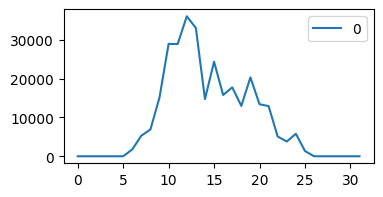

In [5]:
plt.rcParams["figure.figsize"] = (4, 2)

R = np.concatenate((np.zeros(5),data['CONFIRMED']))
R = np.concatenate((R, np.zeros(5)))
R = pd.DataFrame(R)

# plot original and transformed dataset
R.plot()

<Axes: >

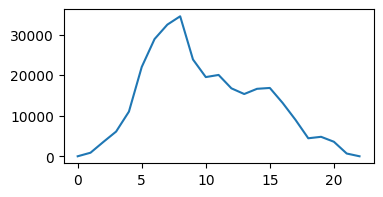

In [6]:
rolling = R.rolling(window=2, center = True)
rolling_mean = rolling.mean()
obsData = rolling_mean[5:28][0].reset_index(drop=True)
obsData.plot()

# MCMC

In [7]:
'''
susceptible (vulnerable to flu infection), 
exposed (asymptomatic and non-infectious), 
infectious (symptomatic, spreading the flu) 
removed (immune to the flu)
'''

'\nsusceptible (vulnerable to flu infection), \nexposed (asymptomatic and non-infectious), \ninfectious (symptomatic, spreading the flu) \nremoved (immune to the flu)\n'

In [8]:
'''
mu, alpha, beta, I0

mu - доля населения, потерявшего иммунитет 
alpha - Fraction of susceptible individuals (vulnerable to flu infection)
        S_0 + E_0 + I_0 = alpha? (доля населения, теряющего иммунитет за год)
beta - вирулентность,  
I0 - Initial fraction of infected (доля переболевших)'''

'\nmu, alpha, beta, I0\n\nmu - доля населения, потерявшего иммунитет \nalpha - Fraction of susceptible individuals (vulnerable to flu infection)\n        S_0 + E_0 + I_0 = alpha? (доля населения, теряющего иммунитет за год)\nbeta - вирулентность,  \nI0 - Initial fraction of infected (доля переболевших)'

In [9]:
def metrics_and_plot(df, optimal_parameters):
    args = optimal_parameters
    N = 4581854.0

    def model_resid(args):
        mu, alpha, beta, I0 = args
        pop = 4581854.0
        T = len(df)
        
        m = BRModel([[6.528]], pop, mu, 'total', '', '')
        exposed_list, lam_list, a = [I0], [beta], [alpha]
        m.set_attributes()
        m.init_simul_params(exposed_list, lam_list, a)
        m.set_attributes()
    
        Y, population_immunity, rho, r0, rt = m.make_simulation()
        Y = Y[0][0]

        #return Y[:T]
        
        scop = float('-inf')
        out = Y[:T]
        
        for j in range(200):
            R = max(r2_score(obsData,Y[j:j+T]), scop)
            if R!=scop:
                scop = R
                out = Y[j:j+T]
    
        return out

    # Integrate the SIR equations over the time grid, t.
    ret = model_resid(args)

    plt.plot(ret, label = 'Predicted', ls='--')
    plt.plot(obsData, label = 'Actual')
    plt.legend()
    
    r2score = r2_score(obsData, ret )
    print('R^2: ', r2score)
    for param, param_value in zip(['mu','a','beta','I0'], optimal_parameters):
        print(param, ': ', param_value)
    pass

In [19]:
def mh(obsData, init_params, rngseed=None, sampling_method='dram',
      display_chain_panel=True, display_density_panel=True,
      display_pairwise_corr=True, n_sim1=1e3, n_sim2=1e2):
    # 'mh', 'am', 'dr', 'dram'
    # tx corresponds to the days, and ty to the active cases
    tx = np.arange(len(obsData))
    ty = np.array(obsData)
    
    def covid_ss(theta, data):
        ymodel = np.array(model_resid(theta))
        res = ymodel - ty
        ss = (res**2).sum(axis=0)
        return ss  

    def model_resid(args):
        mu, alpha, beta, I0 = args
        pop = 4581854.0
        T = len(ty)

        m = BRModel([[6.528]], pop, mu, 'total', '', '')
        exposed_list, lam_list, a = [I0], [beta], [alpha]
        m.set_attributes()
        m.init_simul_params(exposed_list, lam_list, a)
        m.set_attributes()

        Y, population_immunity, rho, r0, rt = m.make_simulation()
        Y = Y[0][0]
        return Y[:T]#60:60+T]

    # initialize MCMC object
    mcstat = MCMC(rngseed=rngseed)
    # initialize data structure 
    mcstat.data.add_data_set(x=tx, y=ty, user_defined_object=tx)
    # initialize parameter array
    # Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
    for param in init_params.keys():
        param_info = init_params[param]
        if param_info[1]=='uniform':
            mcstat.parameters.add_model_parameter(name=param, theta0=param_info[0], 
                                                  minimum=param_info[2], maximum=param_info[3],sample=param_info[4])
        elif param_info[1]=='normal':
            mcstat.parameters.add_model_parameter(name=param, theta0=param_info[0], 
                                                  prior_mu=param_info[2], prior_sigma=param_info[3],sample=param_info[4],
                                                 minimum=param_info[5], maximum=param_info[6])
        
    # Generate options
    mcstat.simulation_options.define_simulation_options(nsimu=n_sim1, updatesigma=True,
                                                       method=sampling_method)
    
    mcstat.model_settings.define_model_settings(
        sos_function=covid_ss)

    # Run simulation
    mcstat.run_simulation()
    # Rerun starting from results of previous run
    mcstat.simulation_options.nsimu = int(n_sim2)
    mcstat.run_simulation(use_previous_results=True)
    
    # extract info from results
    results = mcstat.simulation_results.results
    burnin = int(results['nsimu']/2)
    chain = results['chain'][burnin:, :]
    s2chain = results['s2chain'][burnin:, :]
    names = results['names'] # parameter names

    # display chain stats
    mcstat.chainstats(chain, results)
    settings = dict(fig=dict(figsize=(6, 5)))
    
    if display_chain_panel:
        # plot chain panel
        mcp.plot_chain_panel(chain, names, settings)
    if display_density_panel:
        # uses a Kernel Density Estimator to generate a probability distribution
        mcp.plot_density_panel(chain, names, hist_on=True,
                               settings = dict(hist=dict(color='g',alpha=0.5),
                                               fig=dict(figsize=(6, 5))))
    '''
    settings = dict(add_5095_contours=True, plot_95=dict(color='r',linewidth=3),
                    plot_50=dict(color='c',linewidth=3),
                    add_legend=True, legend=dict(loc='upper right',fontsize=10,
                                                 bbox_to_anchor=(0.85, 0.75)),
                    fig=dict(figsize=(7,6)))'''
    if display_pairwise_corr:
        f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

    return mcstat, results['theta']


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.20 [ 0.00e+00,      1.00] N(     0.20,     0.20^2)
         a:  1.80e-03 [ 0.00e+00,      1.00] N( 1.80e-03, 1.00e-02^2)
      beta:    904.92 [   500.00,   1500.00] N(   904.00,   200.00^2)
        I0:      0.03 [ 0.00e+00,      1.00] N(     0.03,     0.10^2)
 [-----------------100%-----------------] 1500 of 1500 complete in 527.0 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.17 [ 0.00e+00,      1.00] N(     0.20,     0.20^2)
         a:  2.33e-03 [ 0.00e+00,      1.00] N( 1.80e-03, 1.00e-02^2)
      beta:    979.85 [   500.00,   1500.00] N(   904.00,   200.00^2)
        I0:      0.03 [ 0.00e+00,      1.00] N(     0.03,     0.10^2)
 [-----------------100%-----------------] 1501 of 1500 complete in 512.9 sec

------------------------------
      name:      mean       std    MC_err       tau    geweke

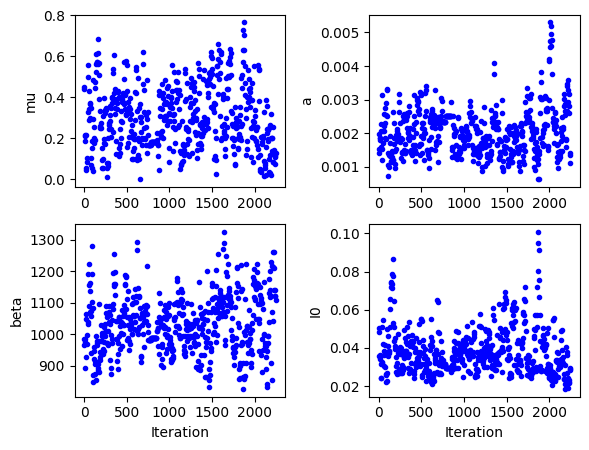

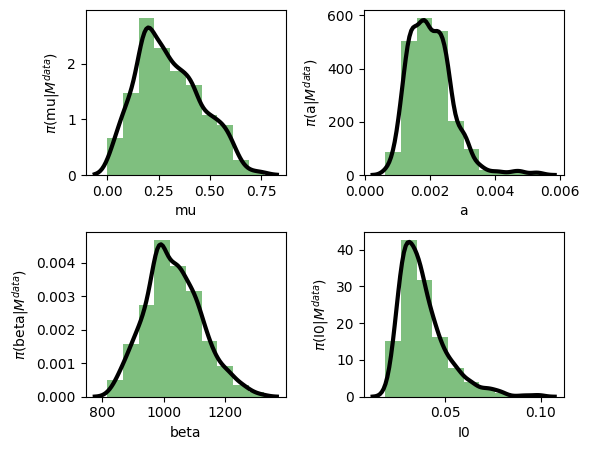

In [41]:
'''
https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
https://iopscience.iop.org/article/10.3847/1538-4365/aab76e/pdf
'''
'''
Metropolis-Hastings (MH): Primary sampling method.
Adaptive-Metropolis (AM): adapt the proposal distribution as information is
learned about the posterior distribution from accepted candidates
Delayed-Rejection (DR): Delays rejection. helps to stimulate
mixing within the sampling chain
'''
# init value, distr name, param0, param1, to_sample. Params for uniform -- minimum, maximum; for normal -- mu, sigma
init_params = dict({'mu': [0.9092460318123954, 'uniform', 0, 1, True],
                     'a': [0.001802514427547769, 'uniform', 0, 1, True],
                     'beta': [904.9228853554217, 'uniform', 500, 1500, True],
                     'I0': [0.2882931865945249, 'uniform', 0, 1, True]})
# + min max
init_params = dict({'mu': [0.9092460318123954, 'normal', 0.909, 0.2, True, 0, 1],
                     'a': [0.001802514427547769, 'normal', 0.0018, 0.01, True, 0, 1],
                     'beta': [904.9228853554217, 'normal', 904, 200, True, 500, 1500],
                     'I0': [0.2882931865945249, 'normal', 0.288, 0.1, True, 0, 1]})
init_params = dict({'mu': [0.195, 'normal', 0.195, 0.2, True, 0, 1],
                     'a': [0.001802514427547769, 'normal', 0.0018, 0.01, True, 0, 1],
                     'beta': [904.9228853554217, 'normal', 904, 200, True, 500, 1500],
                     'I0': [0.029, 'normal', 0.029, 0.1, True, 0, 1]})
# dram, am - baddddd
mcstat, results = mh(obsData, init_params=init_params, rngseed=None,
                     sampling_method='dram',
                     display_pairwise_corr=False, n_sim1=1500, n_sim2=1500)

In [ ]:

init_params = dict({'mu': [0.195, 'normal', 0.195, 0.2, True, 0, 1],
                     'a': [0.001802514427547769, 'normal', 0.0018, 0.01, True, 0, 1],
                     'beta': [904.9228853554217, 'normal', 904, 200, True, 500, 1500],
                     'I0': [0.029, 'normal', 0.029, 0.1, True, 0, 1]})
mcstat1, _ = mh(obsData, init_params=init_params, rngseed=None,
                     sampling_method='dram',
                     display_pairwise_corr=False, n_sim1=1000, n_sim2=500)

init_params = dict({'mu': [0.09, 'normal', 0.195, 0.2, True, 0, 1],
                     'a': [0.001802514427547769, 'normal', 0.0018, 0.01, True, 0, 1],
                     'beta': [904.9228853554217, 'normal', 904, 200, True, 500, 1500],
                     'I0': [0.01, 'normal', 0.029, 0.1, True, 0, 1]})
mcstat2, _ = mh(obsData, init_params=init_params, rngseed=None,
                     sampling_method='dram',
                     display_pairwise_corr=False, n_sim1=1000, n_sim2=500)

init_params = dict({'mu': [0.29, 'normal', 0.195, 0.2, True, 0, 1],
                     'a': [0.001802514427547769, 'normal', 0.0018, 0.01, True, 0, 1],
                     'beta': [904.9228853554217, 'normal', 904, 200, True, 500, 1500],
                     'I0': [0.05, 'normal', 0.029, 0.1, True, 0, 1]})
mcstat3, _ = mh(obsData, init_params=init_params, rngseed=None,
                     sampling_method='dram',
                     display_pairwise_corr=False, n_sim1=1000, n_sim2=500)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.20 [ 0.00e+00,      1.00] N(     0.20,     0.20^2)
         a:  1.80e-03 [ 0.00e+00,      1.00] N( 1.80e-03, 1.00e-02^2)
      beta:    904.92 [   500.00,   1500.00] N(   904.00,   200.00^2)
        I0:      0.03 [ 0.00e+00,      1.00] N(     0.03,     0.10^2)
 [-----------------100%-----------------] 1001 of 1000 complete in 349.8 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.28 [ 0.00e+00,      1.00] N(     0.20,     0.20^2)
         a:  1.44e-03 [ 0.00e+00,      1.00] N( 1.80e-03, 1.00e-02^2)
      beta:   1175.76 [   500.00,   1500.00] N(   904.00,   200.00^2)
        I0:      0.03 [ 0.00e+00,      1.00] N(     0.03,     0.10^2)
 [-----------------100%-----------------] 501 of 500 complete in 160.9 sec

------------------------------
      name:      mean       std    MC_err       tau    geweke
 

R^2:  0.5893995288495586
mu :  0.315116574391458
a :  0.001993327339978901
beta :  1029.9019527348232
I0 :  0.03564022539755558
R^2:  0.5686024737172894
mu :  0.26499217740711045
a :  0.0018129954966224898
beta :  1036.2337513551556
I0 :  0.03442143458751138
R^2:  0.572824400125121
mu :  0.2579709884956696
a :  0.00184776108703214
beta :  1021.9500096722011
I0 :  0.03502601744749739


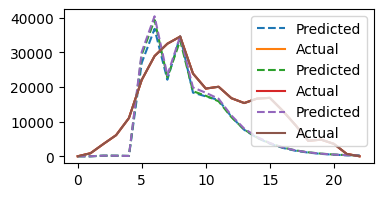

In [48]:
for model in [mcstat1,mcstat2,mcstat3]:
    results_chain = model.simulation_results.results
    burnin = int(results_chain['nsimu']/2)
    chain = results_chain['chain'][burnin:, :]
    metrics_and_plot(obsData, np.median(chain, 0))

R^2:  0.5893995288495586
mu :  0.315116574391458
a :  0.001993327339978901
beta :  1029.9019527348232
I0 :  0.03564022539755558


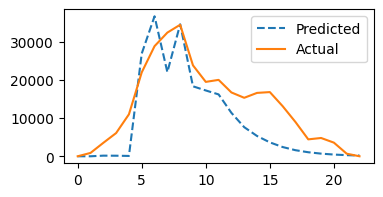

In [49]:
results_chain = mcstat1.simulation_results.results
burnin = int(results_chain['nsimu']/2)
chain = results_chain['chain'][burnin:, :]
metrics_and_plot(obsData, np.median(chain, 0))

In [42]:
results_chain = mcstat.simulation_results.results
burnin = int(results_chain['nsimu']/2)
chain = results_chain['chain'][burnin:, :]
np.mean(chain, 0), np.median(chain, 0)

(array([3.01857189e-01, 2.03474751e-03, 1.03190870e+03, 3.83223796e-02]),
 array([2.80361694e-01, 1.95908189e-03, 1.02603422e+03, 3.55549976e-02]))

R^2:  0.5796704231885044
mu :  0.2803616935440578
a :  0.0019590818909305968
beta :  1026.0342239242389
I0 :  0.03555499764241989


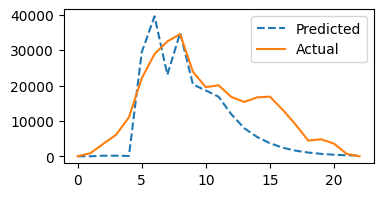

In [45]:
'''
mu :  0.19575011391161065 доля населения, потерявшего иммунитет 
a :  0.0024819323333611916 доля населения, теряющего иммунитет за год 
                        Fraction of susceptible/ vulnerable to flu infection
beta :  1086.9920577431217 вирулентность
I0 :  0.029357057902748916 Initial fraction of infected доля переболевших

R^2:  0.5893995288495586
mu :  0.315116574391458
a :  0.001993327339978901
beta :  1029.9019527348232
I0 :  0.03564022539755558

R^2:  0.5719283806595453
mu :  0.8701432330552042
a :  0.0015119995732607492
beta :  904.9131979791026
I0 :  0.22319606586921253
'''
metrics_and_plot(obsData, np.median(chain, 0))

R^2:  0.5878546611407063
mu :  0.9092460318123954
a :  0.001802514427547769
beta :  904.9228853554217
I0 :  0.2882931865945249


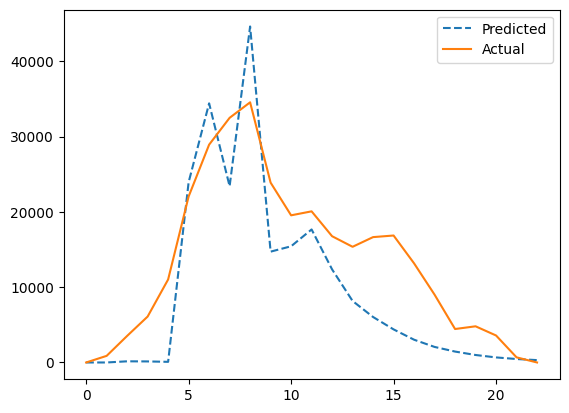

In [15]:
optimal_parameters = [0.9092460318123954,0.001802514427547769,
                      904.9228853554217,0.2882931865945249]
metrics_and_plot(obsData, optimal_parameters)

In [ ]:
def model_resid(data, args):
    mu, alpha, beta, I0 = args
    pop = 4581854.0
    T = data.get_number_of_observations()[0]# len(df)

    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]

    scop = float('-inf')
    out = Y[:T]
    '''
    for j in range(200):
        R = max(r2_score(obsData,Y[j:j+T]), scop)
        if R!=scop:
            scop = R
            out = Y[j:j+T]

    return out
    '''
    
mcstat.PI.setup_prediction_interval_calculation(
    results=mcstat.simulation_results.results,
    data=mcstat.data,
    modelfunction=model_resid)

mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int=False)

# plot prediction intervals
mcstat.PI.plot_prediction_intervals(adddata=True)
plt.xlabel('days', Fontsize=20)
plt.xticks(Fontsize=20)
plt.ylabel('n Confirmed', Fontsize=20)
plt.yticks(Fontsize=20)
plt.title('Predictive envelopes of the model', Fontsize=20)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.91 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
         a:  1.80e-03 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
      beta:    904.92 [   500.00,   1500.00] N( 0.00e+00,      inf)
        I0:      0.29 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 3000 of 3000 complete in 644.2 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.90 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
         a:  2.12e-03 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
      beta:   1132.87 [   500.00,   1500.00] N( 0.00e+00,      inf)
        I0:      0.23 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 3001 of 3000 complete in 694.0 sec

------------------------------
      name:      mean       std    MC_err       tau    geweke
        mu:    

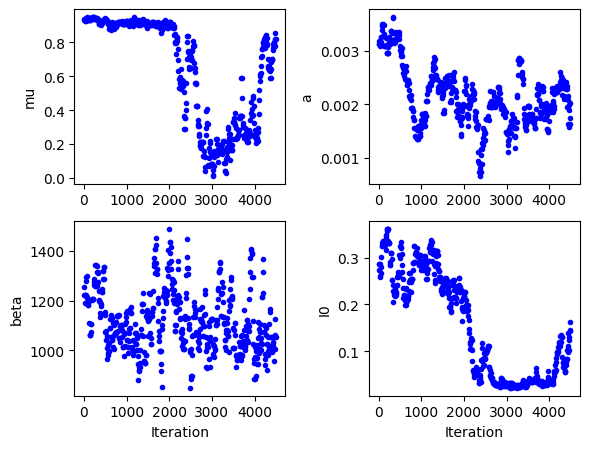

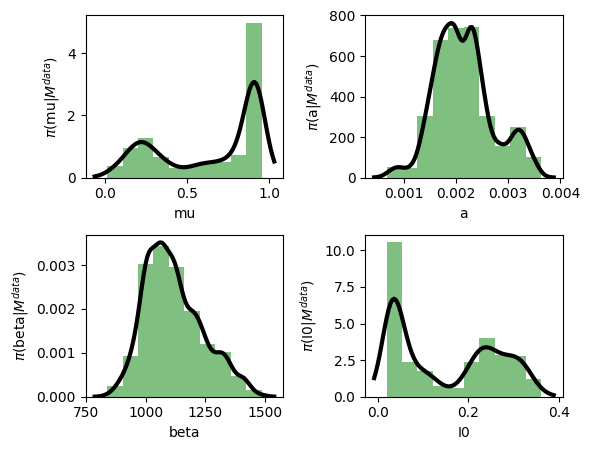

In [11]:
# init value, distr name, param0, param1. For uniform -- minimum, maximum; for normal -- mu, sigma.
init_params = dict({'mu': [0.9092460318123954, 'uniform', 0, 1],
                     'a': [0.001802514427547769, 'uniform', 0, 1],
                     'beta': [904.9228853554217, 'uniform', 500, 1500],
                     'I0': [0.2882931865945249, 'uniform', 0, 1]})

mcstat, results = mh(obsData, init_params=init_params, rngseed=None,
                     sampling_method='mh',
                     display_pairwise_corr=False, n_sim1=3e3, n_sim2=3e3)

In [34]:
results_chain = mcstat.simulation_results.results
burnin = int(results_chain['nsimu']/2)
chain = results_chain['chain'][burnin:, :]
np.mean(chain, 0), np.median(chain, 0)

(array([8.78247671e-01, 1.85282531e-03, 1.03117963e+03, 2.45775230e-01]),
 array([8.89230782e-01, 1.74460104e-03, 1.02096199e+03, 2.41375937e-01]))

R^2:  0.551041425567226
mu :  0.8892307822476225
a :  0.0017446010417886374
beta :  1020.9619939163277
I0 :  0.2413759373414807


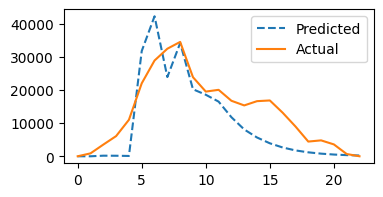

In [35]:
metrics_and_plot(obsData, np.median(chain, 0))

In [23]:
# Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(2000)
mcstat.run_simulation(use_previous_results=True)

# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)
settings = dict(fig=dict(figsize=(6, 5)))

mcp.plot_chain_panel(chain, names, settings)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.83 [     0.50,      1.00] N( 0.00e+00,      inf)
         a:  1.61e-03 [ 0.00e+00,      0.20] N( 0.00e+00,      inf)
      beta:   1111.02 [   700.00,   1200.00] N( 0.00e+00,      inf)
        I0:      0.13 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
 [------           16%                  ] 337 of 2000 complete in 29.3 sec


KeyboardInterrupt



# Parallel -- TT_TT

In [20]:
from pymcmcstat.ParallelMCMC import ParallelMCMC
from datetime import datetime

In [21]:
init_params = dict({'mu': [0.9092460318123954, 'uniform', 0, 1],
                     'a': [0.001802514427547769, 'uniform', 0, 1],
                     'beta': [904.9228853554217, 'uniform', 500, 1500],
                     'I0': [0.2882931865945249, 'uniform', 0, 1]})

In [22]:
rngseed=None
sampling_method='mh'
n_sim1=1e2
# tx corresponds to the days, and ty to the active cases
tx = np.arange(len(obsData))
ty = np.array(obsData)

def covid_ss(theta, data):
    ymodel = np.array(model_resid(theta))
    res = ymodel - ty
    ss = (res**2).sum(axis=0)
    return ss  

def model_resid(args):
    mu, alpha, beta, I0 = args
    pop = 4581854.0
    T = len(ty)

    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]
    return Y[:T]#60:60+T]

# initialize MCMC object
mcstat = MCMC(rngseed=rngseed)
# initialize data structure 
mcstat.data.add_data_set(x=tx, y=ty, user_defined_object=tx)
# initialize parameter array
# Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
mcstat.model_settings.define_model_settings(sos_function=covid_ss)

for param in init_params.keys():
    param_info = init_params[param]
    if param_info[1]=='uniform':
        mcstat.parameters.add_model_parameter(name=param, theta0=param_info[0], 
                                              minimum=param_info[2], maximum=param_info[3])
    elif param_info[1]=='normal':
        mcstat.parameters.add_model_parameter(name=param, theta0=param_info[0], 
                                              prior_mu=param_info[2], prior_sigma=param_info[3])

datestr = datetime.now().strftime('%Y%m%d_%H%M%S')
savedir = 'resources' + os.sep + str('{}_{}'.format(datestr, 'parallel_chains'))     
# Generate options
mcstat.simulation_options.define_simulation_options(nsimu=n_sim1, updatesigma=True,
                                                   method=sampling_method,
                                                   savedir=savedir, savesize=1000, save_to_json=True,
                                                    verbosity=1, waitbar=True, save_lightly=True, 
                                                    save_to_bin=True)


In [23]:
# setup parallel MCMC
parMC = ParallelMCMC()
initial_values = np.array([[],[],[]]) # n_chains x n_parameters
parMC.setup_parallel_simulation(mcset=mcstat,
                                #initial_values=initial_values,
                                num_chain=2,
                                num_cores=1)

In [ ]:
parMC.run_parallel_simulation()
parMC.display_individual_chain_statistics()

In [23]:
(ind_data-ind_pr, ma_data/ma_pr)

(-1, 0.7742680583233457)

In [ ]:
Нужно уточнить про данные!!!!

# ABC

In [15]:
def model(theta, T):
    T = len(obsData)
    mu, alpha, beta, I0 = theta

    pop = 4581854.0

    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]

    scop = float('-inf')
    out = Y[:T]

    ma = max(obsData)
    prMVal = max(Y[:T])
    #prMInd = list(Y).index(prMVal)

    if prMVal>0:
        s = prMVal/ma
        Y/=s
    
    # for j in range(200):
    #     R = max(r2_score(obsData,Y[j:j+T]), scop)
    #     if R!=scop:
    #         scop = R
    #         out = Y[j:j+T]

    return out

  0%|          | 0/3 [00:00<?, ?it/s]

Posterior mean of mu:     0.5203379912779895
Posterior mean of alpha:  0.5464284041572465
Posterior mean of beta:   716.2435480113653
Posterior mean of I0:     0.14177466787767518
R^2:                      -0.5070702801863471


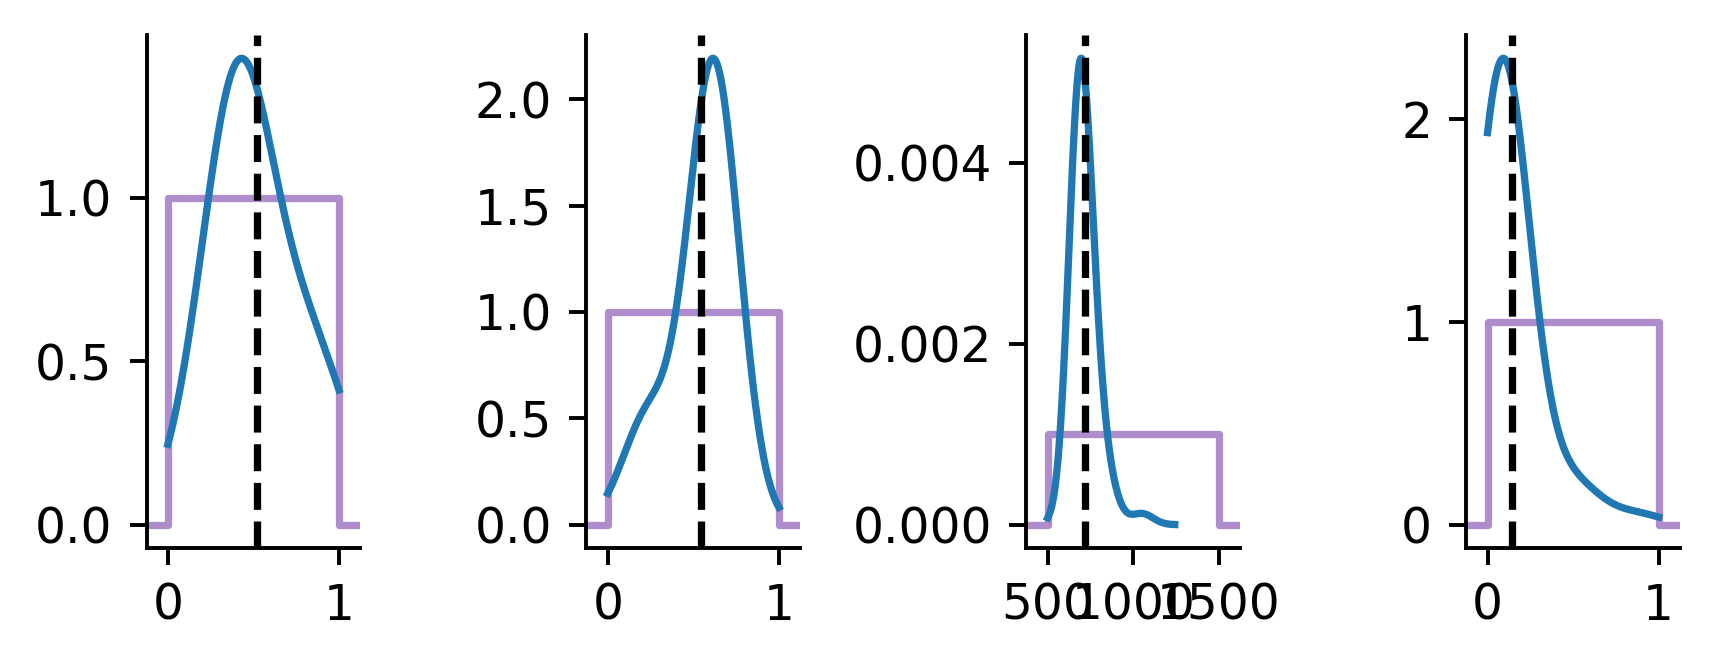

In [17]:
#                                      mu,   alpha,   beta,  exposed
prior = abc.IndependentUniformPrior([(0, 1), (0, 1), (500, 1500), (0,1)])

# Fit the model to the data using ABC
numIters = 3  # The number of SMC iterations to perform
popSize = 10# The population size of the SMC method

    
simulator = lambda theta: model(theta, len(obsData))
fit = abc.smc(numIters, popSize, obsData, simulator, prior, 
              showProgressBar=True, numProcs=2, plotProgress=False)

theta = (np.sum(fit.samples[:, 0] * fit.weights), 
         np.sum(fit.samples[:, 1] * fit.weights), 
         np.sum(fit.samples[:, 2] * fit.weights), 
         np.sum(fit.samples[:, 3] * fit.weights))


abc.plot_posteriors(fit, prior, refLines=theta)

predictions = simulator(theta)

print("Posterior mean of mu:    ", theta[0])
print("Posterior mean of alpha: ", theta[1])
print("Posterior mean of beta:  ", theta[2])
print("Posterior mean of I0:    ", theta[3])
print("R^2:                     ", r2_score(obsData, predictions))

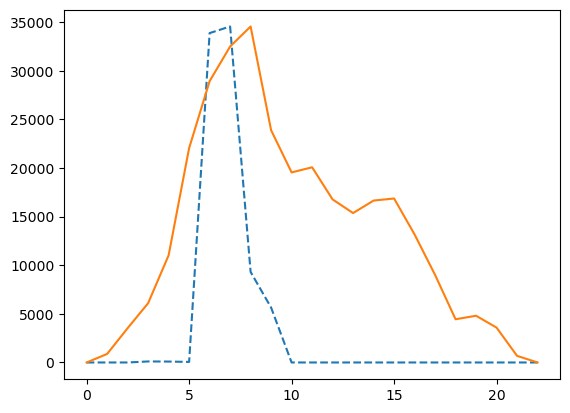

In [19]:
plt.plot(predictions, ls='--')
plt.plot(obsData)